### Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt

### Configuration

In [2]:
IMG_SIZE = (128, 128, 1)  # Image size with channel
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001
DATA_DIR = "processed_dataset_npy"  

### Loading the data

In [3]:
X = []
y = []
DATA_DIR = "processed_dataset_npy"

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".npy"):
            rel_path = os.path.relpath(root, DATA_DIR) 
            class_name = rel_path.split(os.sep)[0] 
            label = 1 if class_name.lower() == "fraud" else 0
            file_path = os.path.join(root, file)
            img = np.load(file_path)
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)
print(f"Total Data = {len(X)}")

Total Data = 2176


### Train and Test Split

In [4]:
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)  # channel dimension
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Data = {len(X_train)}\nTest Data = {len(X_test)}")

Train Data = 1740
Test Data = 436


### Model Building and Compilation

In [5]:
cnn_model = models.Sequential([
    layers.Input(shape=IMG_SIZE),  

    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

cnn_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# callbacks for training
checkpoint = ModelCheckpoint("cnn_model.keras", save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,273 (6.34 MB)

 Trainable params: 1,661,953 (6.34 MB)

 Non-trainable params: 320 (1.25 KB)

### Training the Model

In [6]:
history = cnn_model.fit(
    X_train, y_train, batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop],
)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5192 - loss: 2.0796 - val_accuracy: 0.5092 - val_loss: 2.5896
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5947 - loss: 0.6739 - val_accuracy: 0.5092 - val_loss: 2.0071
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6618 - loss: 0.6197 - val_accuracy: 0.5115 - val_loss: 2.3034
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7287 - loss: 0.5602 - val_accuracy: 0.5688 - val_loss: 1.7106
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7688 - loss: 0.5567 - val_accuracy: 0.5573 - val_loss: 0.8897
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7811 - loss: 0.4684 - val_accuracy: 0.7294 - val_loss: 0.6227
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8103 - loss: 0.4191 - val_accuracy: 0.7546 - val_loss: 0.5042
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8143 - loss: 0.4218 - val_accu

### Visualize Training and Validation

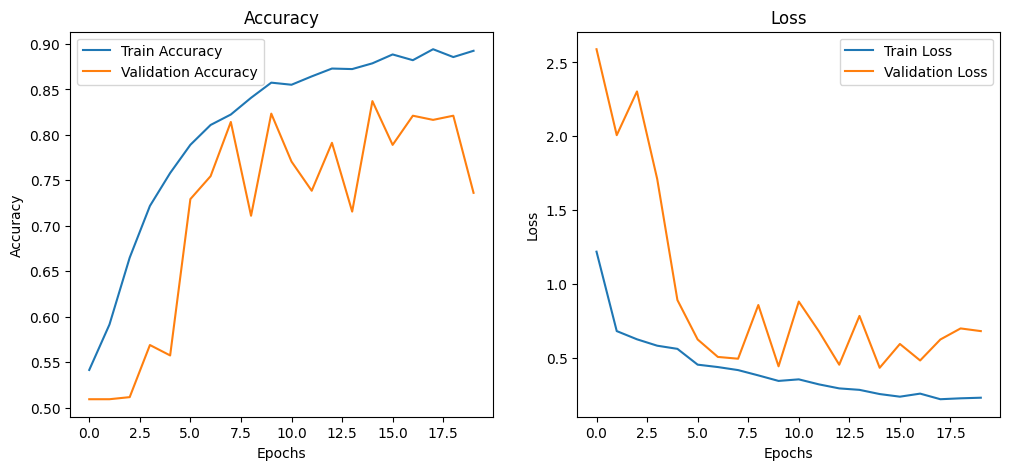

In [7]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluating the Model

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       222
           1       0.80      0.84      0.82       214

    accuracy                           0.82       436
   macro avg       0.82      0.82      0.82       436
weighted avg       0.82      0.82      0.82       436



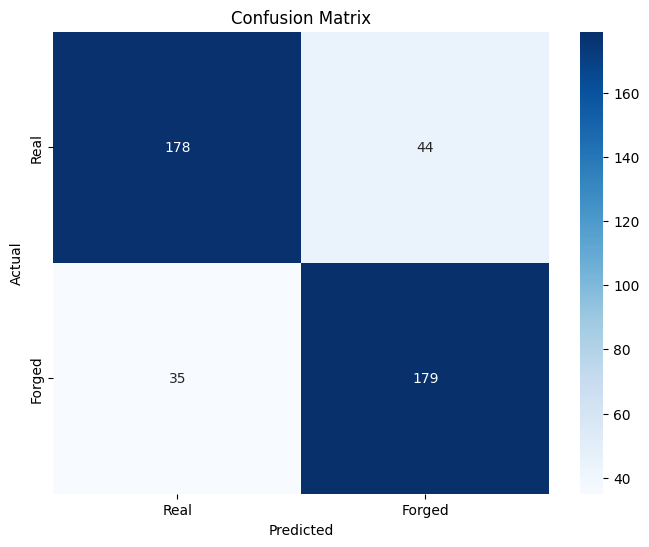

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


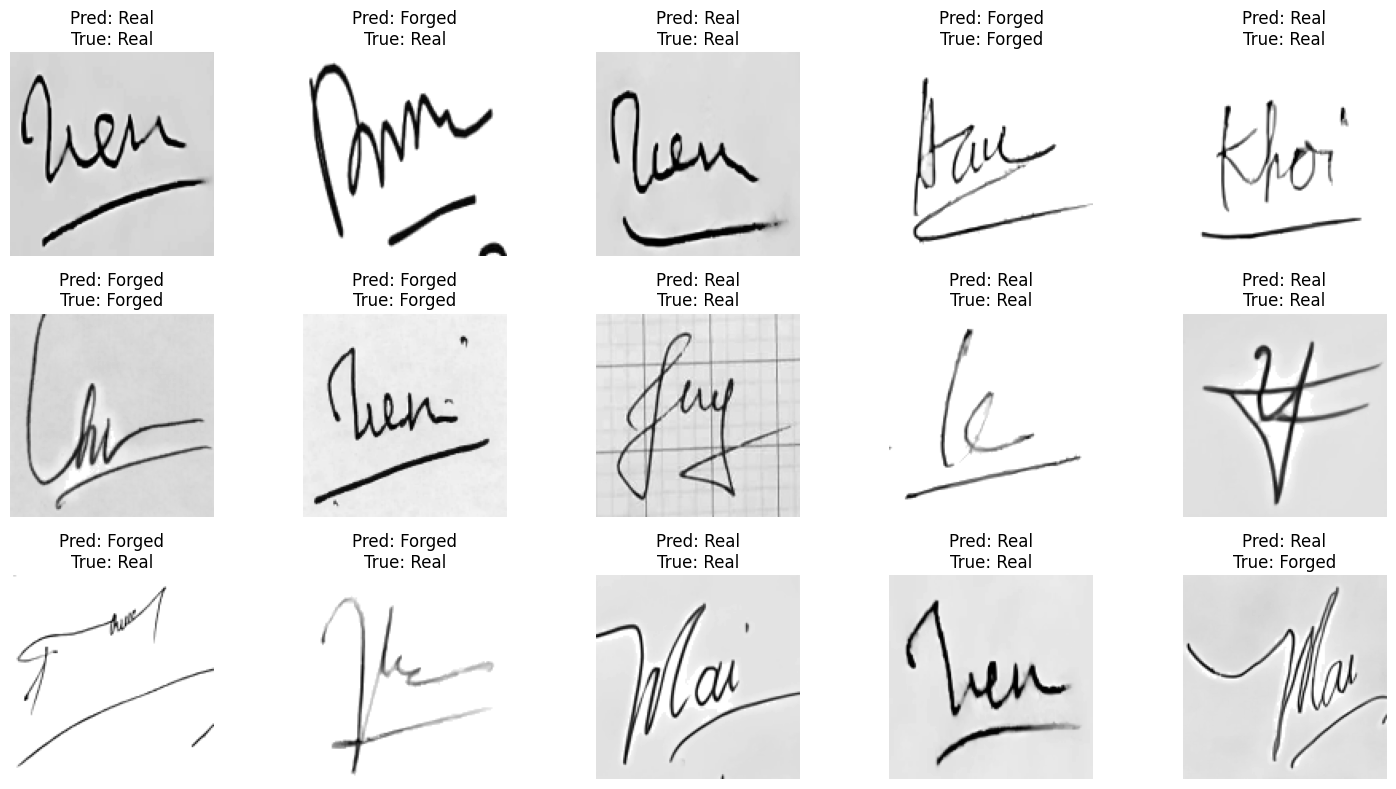

In [25]:
# Evaluation on test data
y_pred_prob = cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.4725).astype("int32")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Forged"], yticklabels=["Real", "Forged"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualize predictions on 15 random test images
import random

# Randomly select 15 indices from the test set
indices = np.random.choice(len(X_test), size=15, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]

# Get predictions for these samples
sample_pred_prob = cnn_model.predict(sample_images)
sample_preds = (sample_pred_prob > 0.4725).astype("int32").flatten()

# Map numeric labels to string labels
label_map = {0: "Real", 1: "Forged"}

# Plot the images with predicted and true labels
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_images[i].reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
    plt.title(f"Pred: {label_map[sample_preds[i]]}\nTrue: {label_map[sample_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
